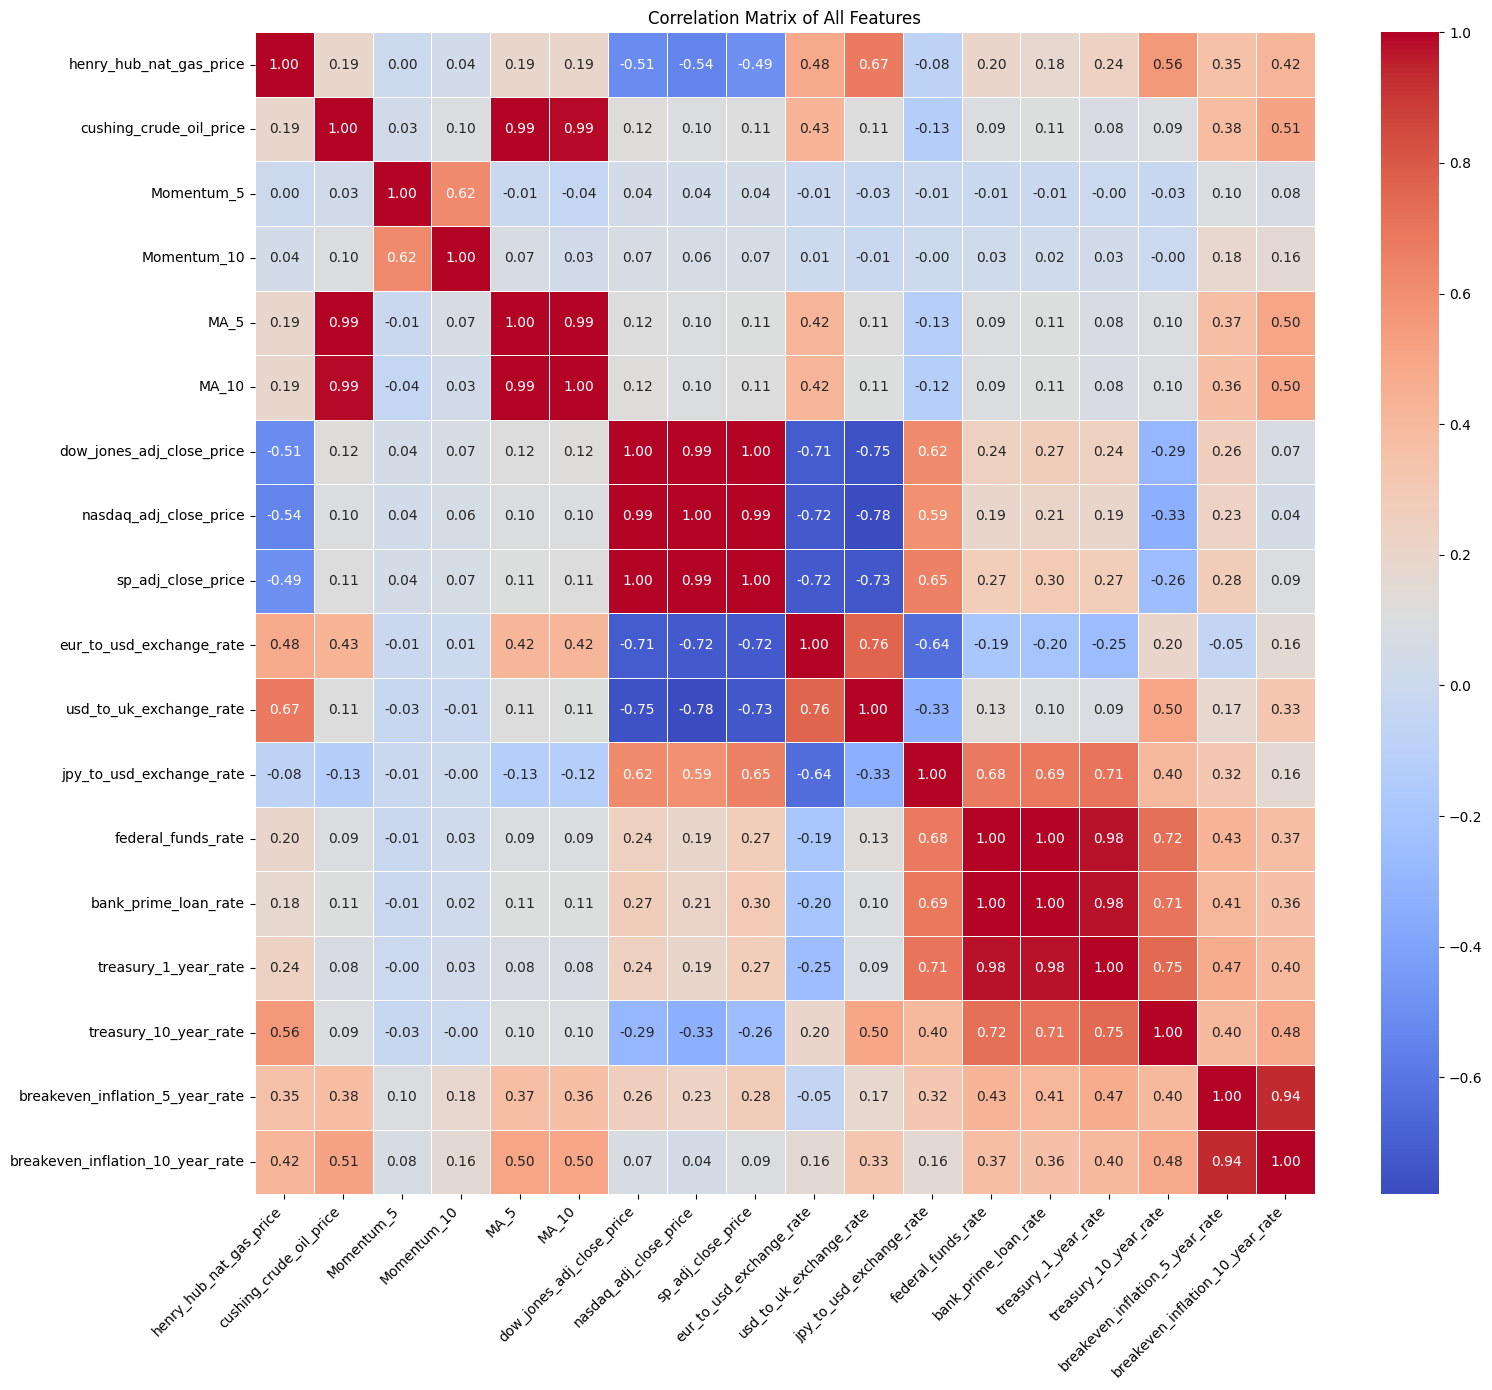

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('compiled_dataset.csv')

# Lọc các cột số để tính tương quan
numerical_df = df.select_dtypes(include=[np.number])

# Tính ma trận tương quan
corr_matrix = numerical_df.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

Version 1

Epoch [1/50] - Train Loss: 0.301483, Test Loss: 0.169391
Epoch [2/50] - Train Loss: 0.030632, Test Loss: 0.033059
Epoch [3/50] - Train Loss: 0.015140, Test Loss: 0.009972
Epoch [4/50] - Train Loss: 0.010197, Test Loss: 0.004030
Epoch [5/50] - Train Loss: 0.007322, Test Loss: 0.005165
Epoch [6/50] - Train Loss: 0.005429, Test Loss: 0.008892
Epoch [7/50] - Train Loss: 0.004201, Test Loss: 0.010589
Epoch [8/50] - Train Loss: 0.003203, Test Loss: 0.009036
Epoch [9/50] - Train Loss: 0.002250, Test Loss: 0.005970
Epoch [10/50] - Train Loss: 0.001372, Test Loss: 0.003830
Epoch [11/50] - Train Loss: 0.000758, Test Loss: 0.001890
Epoch [12/50] - Train Loss: 0.000459, Test Loss: 0.001059
Epoch [13/50] - Train Loss: 0.000364, Test Loss: 0.000796
Epoch [14/50] - Train Loss: 0.000323, Test Loss: 0.000684
Epoch [15/50] - Train Loss: 0.000300, Test Loss: 0.000686
Epoch [16/50] - Train Loss: 0.000284, Test Loss: 0.000555
Epoch [17/50] - Train Loss: 0.000272, Test Loss: 0.000513
Epoch [18/50] - Train L

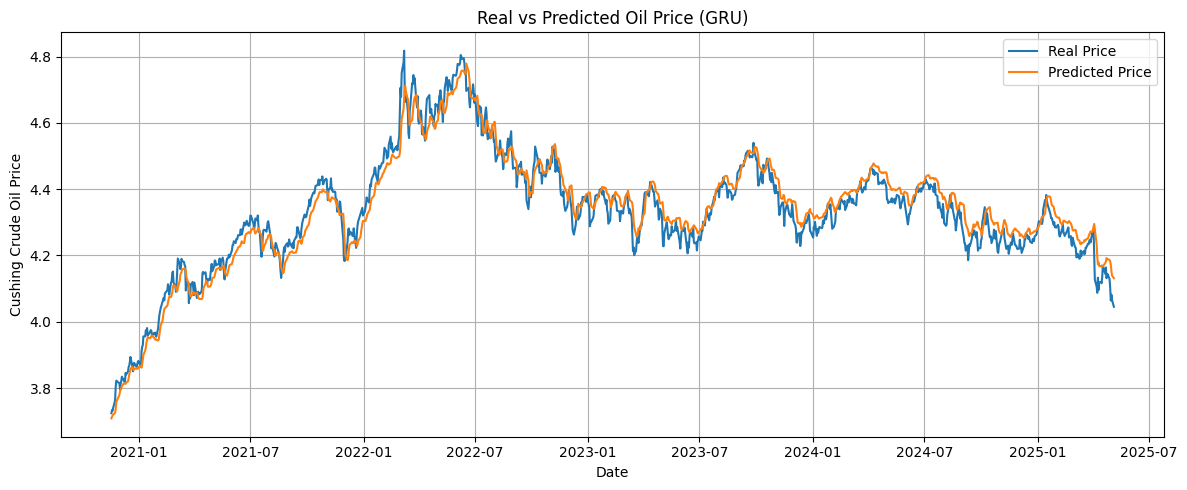

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]].copy()
data = data.sort_values('Date').reset_index(drop=True)

feature_cols = [
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'breakeven_inflation_5_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
    'cushing_crude_oil_price',
]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_values = data[feature_cols].values
target_values = data[[target]].values

scaled_features = feature_scaler.fit_transform(features_values)
scaled_target = target_scaler.fit_transform(target_values)

dates = data['Date'].values

def create_sequences(features_arr, target_arr, lookback=30):
    X_list = []
    y_list = []
    for i in range(lookback, len(features_arr)):
        X_list.append(features_arr[i - lookback:i])
        y_list.append(target_arr[i])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

lookback = 30
X, y = create_sequences(scaled_features, scaled_target, lookback=lookback)
sample_dates = dates[lookback:]

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

dates_train = sample_dates[:train_size]
dates_test = sample_dates[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_train.shape[-1]
hidden_size = 32
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRURegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)
    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")

checkpoint = {
    "model_state_dict": model.state_dict(),
    "feature_scaler": feature_scaler,
    "target_scaler": target_scaler,
    "lookback": lookback,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
}
torch.save(checkpoint, "gru_oil_price_checkpoint.pth")
print("Checkpoint saved to gru_oil_price_checkpoint.pth")

model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_real = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R^2 :", r2)

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_real.flatten(), label="Real Price")
plt.plot(dates_test, y_pred.flatten(), label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Cushing Crude Oil Price")
plt.title("Real vs Predicted Oil Price (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Version 2

Original shape: (5609, 6)
Shape after dropping NaNs: (5609, 6)
Epoch [1/50] - Train Loss: 0.051101, Test Loss: 0.002264
Epoch [2/50] - Train Loss: 0.011418, Test Loss: 0.002588
Epoch [3/50] - Train Loss: 0.009821, Test Loss: 0.002963
Epoch [4/50] - Train Loss: 0.007944, Test Loss: 0.002263
Epoch [5/50] - Train Loss: 0.004975, Test Loss: 0.000738
Epoch [6/50] - Train Loss: 0.001090, Test Loss: 0.000401
Epoch [7/50] - Train Loss: 0.000567, Test Loss: 0.000364
Epoch [8/50] - Train Loss: 0.000538, Test Loss: 0.000407
Epoch [9/50] - Train Loss: 0.000523, Test Loss: 0.000374
Epoch [10/50] - Train Loss: 0.000508, Test Loss: 0.000362
Epoch [11/50] - Train Loss: 0.000496, Test Loss: 0.000314
Epoch [12/50] - Train Loss: 0.000493, Test Loss: 0.000357
Epoch [13/50] - Train Loss: 0.000488, Test Loss: 0.000376
Epoch [14/50] - Train Loss: 0.000481, Test Loss: 0.000291
Epoch [15/50] - Train Loss: 0.000489, Test Loss: 0.000417
Epoch [16/50] - Train Loss: 0.000458, Test Loss: 0.000310
Epoch [17/50] - Tr

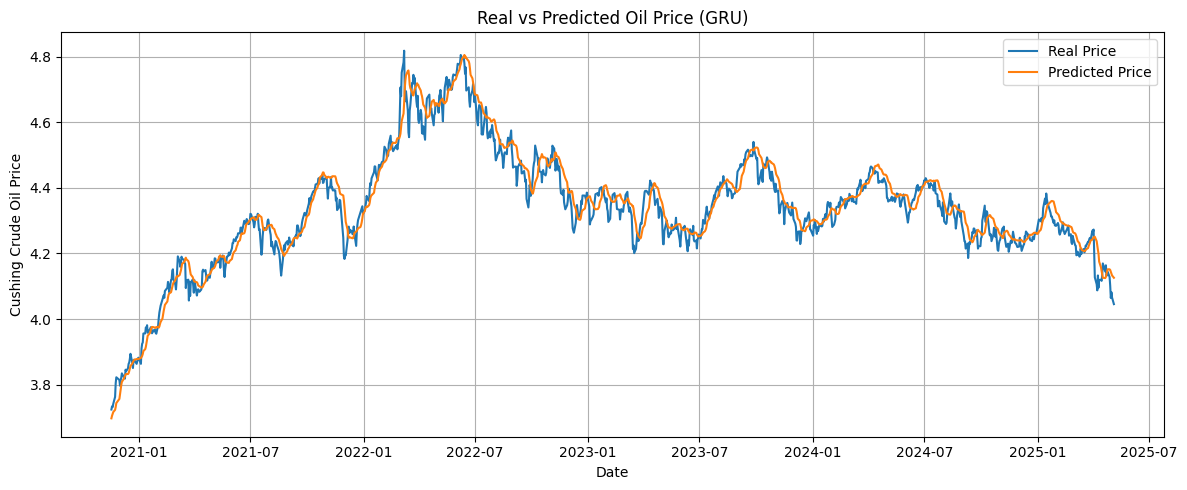

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'MA_5',                             
    'MA_10',                            
    'breakeven_inflation_10_year_rate', 
    #'eur_to_usd_exchange_rate',         
    'breakeven_inflation_5_year_rate'
]

target = 'cushing_crude_oil_price'

data = df[features + [target]].copy()
data = data.sort_values('Date').reset_index(drop=True)

print(f"Original shape: {data.shape}")
data = data.dropna()
print(f"Shape after dropping NaNs: {data.shape}")

feature_cols = [
    'MA_5',                             
    'MA_10',                            
    'breakeven_inflation_10_year_rate', 
    #'eur_to_usd_exchange_rate',         
    'breakeven_inflation_5_year_rate'
]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_values = data[feature_cols].values
target_values = data[[target]].values

scaled_features = feature_scaler.fit_transform(features_values)
scaled_target = target_scaler.fit_transform(target_values)

dates = data['Date'].values

def create_sequences(features_arr, target_arr, lookback=30):
    X_list = []
    y_list = []
    for i in range(lookback, len(features_arr)):
        X_list.append(features_arr[i - lookback:i])
        y_list.append(target_arr[i])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

lookback = 30
X, y = create_sequences(scaled_features, scaled_target, lookback=lookback)
sample_dates = dates[lookback:]

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

dates_train = sample_dates[:train_size]
dates_test = sample_dates[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_train.shape[-1]
hidden_size = 32
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRURegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)
    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")

checkpoint = {
    "model_state_dict": model.state_dict(),
    "feature_scaler": feature_scaler,
    "target_scaler": target_scaler,
    "lookback": lookback,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
}

torch.save(checkpoint, "gru_oil_price_checkpoint.pth")
print("Checkpoint saved to gru_oil_price_checkpoint.pth")

model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_real = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R^2 :", r2)

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_real.flatten(), label="Real Price")
plt.plot(dates_test, y_pred.flatten(), label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Cushing Crude Oil Price")
plt.title("Real vs Predicted Oil Price (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Version 3

Original shape: (5609, 17)
Shape after dropping NaNs: (5609, 17)
Epoch [1/50] - Train Loss: 0.170363, Test Loss: 0.012987
Epoch [2/50] - Train Loss: 0.020482, Test Loss: 0.004902
Epoch [3/50] - Train Loss: 0.013945, Test Loss: 0.006933
Epoch [4/50] - Train Loss: 0.011293, Test Loss: 0.011196
Epoch [5/50] - Train Loss: 0.009754, Test Loss: 0.013533
Epoch [6/50] - Train Loss: 0.008327, Test Loss: 0.014304
Epoch [7/50] - Train Loss: 0.006896, Test Loss: 0.013390
Epoch [8/50] - Train Loss: 0.005346, Test Loss: 0.012139
Epoch [9/50] - Train Loss: 0.003802, Test Loss: 0.010479
Epoch [10/50] - Train Loss: 0.002306, Test Loss: 0.006852
Epoch [11/50] - Train Loss: 0.001312, Test Loss: 0.005151
Epoch [12/50] - Train Loss: 0.000919, Test Loss: 0.002804
Epoch [13/50] - Train Loss: 0.000745, Test Loss: 0.002395
Epoch [14/50] - Train Loss: 0.000650, Test Loss: 0.001368
Epoch [15/50] - Train Loss: 0.000580, Test Loss: 0.001017
Epoch [16/50] - Train Loss: 0.000529, Test Loss: 0.001043
Epoch [17/50] - 

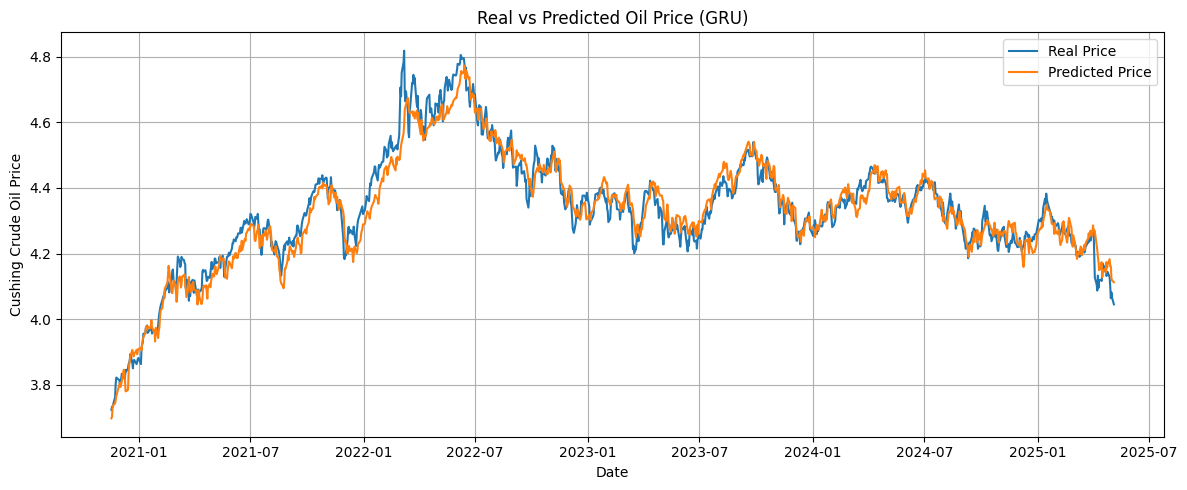

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    'Date',
    'MA_5', 
    'MA_10', 
    'breakeven_inflation_10_year_rate', 
    #'eur_to_usd_exchange_rate', 
    'breakeven_inflation_5_year_rate',
    'henry_hub_nat_gas_price',
    'dow_jones_adj_close_price', 
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'bank_prime_loan_rate',
    'nasdaq_adj_close_price',
    'Momentum_10',
    'federal_funds_rate',
    'treasury_10_year_rate',
    'treasury_1_year_rate',
    'Momentum_5'
]

target = 'cushing_crude_oil_price'

data = df[features + [target]].copy()
data = data.sort_values('Date').reset_index(drop=True)

print(f"Original shape: {data.shape}")
data = data.dropna()
print(f"Shape after dropping NaNs: {data.shape}")

feature_cols = [
    'MA_5', 
    'MA_10', 
    'breakeven_inflation_10_year_rate', 
    #'eur_to_usd_exchange_rate', 
    'breakeven_inflation_5_year_rate',
    'henry_hub_nat_gas_price',
    'dow_jones_adj_close_price', 
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'bank_prime_loan_rate',
    'nasdaq_adj_close_price',
    'Momentum_10',
    'federal_funds_rate',
    'treasury_10_year_rate',
    'treasury_1_year_rate',
    'Momentum_5'
]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_values = data[feature_cols].values
target_values = data[[target]].values

scaled_features = feature_scaler.fit_transform(features_values)
scaled_target = target_scaler.fit_transform(target_values)

dates = data['Date'].values

def create_sequences(features_arr, target_arr, lookback=30):
    X_list = []
    y_list = []
    for i in range(lookback, len(features_arr)):
        X_list.append(features_arr[i - lookback:i])
        y_list.append(target_arr[i])
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

lookback = 30
X, y = create_sequences(scaled_features, scaled_target, lookback=lookback)
sample_dates = dates[lookback:]

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

dates_train = sample_dates[:train_size]
dates_test = sample_dates[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

input_size = X_train.shape[-1]
hidden_size = 32
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRURegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)
    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")

checkpoint = {
    "model_state_dict": model.state_dict(),
    "feature_scaler": feature_scaler,
    "target_scaler": target_scaler,
    "lookback": lookback,
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
}

torch.save(checkpoint, "gru_oil_price_checkpoint.pth")
print("Checkpoint saved to gru_oil_price_checkpoint.pth")

model.eval()
with torch.no_grad():
    X_test_t = X_test_t.to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_real = target_scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("Test MAE :", mae)
print("Test RMSE:", rmse)
print("Test R^2 :", r2)

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_real.flatten(), label="Real Price")
plt.plot(dates_test, y_pred.flatten(), label="Predicted Price")
plt.xlabel("Date")
plt.ylabel("Cushing Crude Oil Price")
plt.title("Real vs Predicted Oil Price (GRU)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
